# Data Collection
### Download data and basic data exploration

### 1. Intro
To get the stock news for specific companies, we will scrape investing.com/equities/(company-name)-news for news. We will get data from 2018-2023. We will get historical data from the Yahoo Finance api.

### 2. Importing libraries

In [95]:
import pandas as pd
import time
import numpy as np
import requests
import nltk
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import re
import datetime
from tqdm import tqdm
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
from newspaper import Article
from htmldate import find_date

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### 3. Web Scraping

In [52]:
# Selenium and webdriver
#!pip install selenium
#!pip install webdriver_manager

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager

In [53]:
def scrape_article_urls(company, start_page, end_page):
    options = webdriver.ChromeOptions()
    #options.add_argument('--headless')
    #options.add_argument('--disable-dev-shm-usage')

    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)

    all_article_urls = []

    for page_number in tqdm(range(start_page, end_page + 1), desc="Scraping article URLs"):
        url = f"https://investing.com/equities/{company}-news/{page_number}"
        try:
            driver.get(url)
        except:
            print("Failed to access url: " + url)
        # driver.implicitly_wait(5)
        article_xpath = '//article'
        articles = driver.find_elements(By.XPATH, article_xpath)
        for article in articles:
            # Get the 'a' tag within the article
            link = article.find_element(By.XPATH, './/a[@href]')

            # Get the href attribute (URL)
            if link:
                article_url = link.get_attribute('href')
                
                # Exclude URLs that contain "/pro" (advertisements)
                if '/pro' not in article_url:
                    all_article_urls.append(article_url)

    driver.quit()
    return all_article_urls

In [76]:
# Company Name:
company_name = "united-tech"
article_urls = scrape_article_urls(company_name, 1, 100)

Scraping article URLs: 100%|████████████████████████████████████| 100/100 [08:13<00:00,  4.93s/it]


In [77]:
article_urls

['https://www.investing.com/news/stock-market-news/lockheed-martin-shares-edge-up-amid-broader-market-gains-93CH-3235833',
 'https://www.investing.com/news/stock-market-news/rtx-corp-announces-dividend-amid-sustainability-concerns-93CH-3234826',
 'https://www.investing.com/news/stock-market-news/singapores-scoot-looking-into-extending-a320ceo-lease-due-to-pratt-engine-issues-3228245',
 'https://www.investing.com/news/stock-market-news/boeing-sees-minor-recovery-amid-mixed-market-results-rtx-corp-outperforms-93CH-3228023',
 'https://www.investing.com/news/stock-market-news/rtx-recovers-from-pratt--whitney-engine-issue-announces-accelerated-share-repurchase-93CH-3218413',
 'https://www.investing.com/news/stock-market-news/raytheon-kongsberg-to-further-develop-nasams-missile-system-norway-says-3214868',
 'https://www.investing.com/news/stock-market-news/ukraine-war-orders-starting-to-boost-revenues-for-big-us-defense-contractors-3211551',
 'https://www.investing.com/news/assorted/rtx-anno

#### 4. Getting Sentiment Scores

In [80]:
def get_sentiment_scores(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    return scores

# Stock ticker symbol:
ticker_symbol = 'RTX'

# Initialize lists
ticker_symbols = []
publish_dates = []
titles = []
body_texts = []
urls = []
neg = []
neu = []
pos = []
compound = []

for url in tqdm(article_urls, desc="Processing Articles"):
    article = Article(url)
    article.download()
    try:
        article.parse()
        # Append data to lists
        ticker_symbols.append(ticker_symbol)
        publish_dates.append(find_date(url))
        titles.append(article.title)
        body_texts.append(article.text)
        urls.append(url)
        # Append sentiment scores to lists
        sentiment_scores = get_sentiment_scores(article.text)
        neg.append(sentiment_scores['neg'])
        neu.append(sentiment_scores['neu'])
        pos.append(sentiment_scores['pos'])
        compound.append(sentiment_scores['compound'])
    except: 
        print("Couldn't process article with url: " + url)
        continue

data = {
    'Ticker Symbol': ticker_symbols,
    'Publish Date': publish_dates,
    'Title': titles,
    'Body Text': body_texts,
    'URL': urls,
    'Negative Score': neg,
    'Neutral Score': neu,
    'Positive Score': pos,
    'Compound Score': compound
}

article_sentiments_df = pd.DataFrame(data)

Processing Articles:  57%|█████████████████████▌                | 518/912 [12:13<20:28,  3.12s/it]

Couldn't process article with url: https://www.investing.com/news/stock-market-news/exclusive-indias-indigo-close-to-mammoth-300plane-airbus-deal--sources-2006280


Processing Articles: 100%|██████████████████████████████████████| 912/912 [22:39<00:00,  1.49s/it]


In [81]:
article_sentiments_df

,Ticker Symbol,Publish Date,Title,Body Text,URL,Negative Score,Neutral Score,Positive Score,Compound Score
0,RTX,2023-11-16,Lockheed Martin shares edge up amid broader ma...,"Published Nov 15, 2023 10:45PM ET\n\nLMT +0.39...",https://www.investing.com/news/stock-market-ne...,0.018,0.848,0.134,0.9887
1,RTX,2023-11-15,RTX Corp announces dividend amid sustainabilit...,"Published Nov 15, 2023 06:21AM ET\n\n© Reuters...",https://www.investing.com/news/stock-market-ne...,0.018,0.868,0.114,0.9930
2,RTX,2023-11-09,Singapore's Scoot looking into extending A320c...,"Published Nov 09, 2023 03:58AM ET\n\n© Reuters...",https://www.investing.com/news/stock-market-ne...,0.035,0.958,0.007,-0.7339
3,RTX,2023-11-09,Boeing sees minor recovery amid mixed market r...,"Published Nov 09, 2023 01:23AM ET\n\n© Reuters...",https://www.investing.com/news/stock-market-ne...,0.013,0.900,0.086,0.8779
4,RTX,2023-11-02,RTX recovers from Pratt & Whitney engine issue...,"Published Nov 02, 2023 04:57AM ET\n\n© Reuters...",https://www.investing.com/news/stock-market-ne...,0.057,0.798,0.145,0.9891
...,...,...,...,...,...,...,...,...,...
906,RTX,2017-07-23,The week ahead: 5 things to watch on the econo...,"Published Jul 23, 2017 04:29AM ET\n\n© Reuters...",https://www.investing.com/news/economy-news/th...,0.007,0.945,0.049,0.9894
907,RTX,2017-07-10,"Ingersoll-Rand may split into two companies, S...",© Reuters. Ingersoll-Rand may split into two c...,https://www.investing.com/news/stock-market-ne...,0.000,1.000,0.000,0.0000
908,RTX,2017-07-07,United Tech tops Dow in week following strong ...,Please try another search,https://www.investing.com/news/stock-market-ne...,0.000,0.566,0.434,0.3182
909,RTX,2017-07-06,Oppenheimer Global ESG Revenue ETF (ESGF) June...,Please try another search,https://www.investing.com/news/stock-market-ne...,0.000,0.566,0.434,0.3182


In [82]:
# Save dataframe
article_sentiments_df.to_pickle(f"../data/processed/{ticker_symbol}_article_sentiments_df.pkl")
article_sentiments_df.to_csv(f"../data/processed/{ticker_symbol}_article_sentiments_df.csv", sep=',', encoding='utf-8', header=True)

In [83]:
# Dropping rows without a publish date
article_sentiments_df = article_sentiments_df.replace(to_replace='None', value=np.nan).dropna()

In [84]:
# Dropping duplicate articles
article_sentiments_df.drop_duplicates(subset="Title", keep="first", inplace=True)

In [85]:
# Setting index to datetime
article_sentiments_df['Date'] = pd.to_datetime(article_sentiments_df['Publish Date'])
article_sentiments_df.set_index('Date', inplace=True)

In [86]:
# Sort in chronological order
article_sentiments_df = article_sentiments_df.sort_index()

In [87]:
# Drop duplicate dates
article_sentiments_df.drop_duplicates(subset="Publish Date", keep="first", inplace=True)

In [88]:
article_sentiments_df

,Ticker Symbol,Publish Date,Title,Body Text,URL,Negative Score,Neutral Score,Positive Score,Compound Score
Date,,,,,,,,,
2017-06-23,RTX,2017-06-23,Layoffs planned at Carrier By Seeking Alpha,Please try another search,https://www.investing.com/news/stock-market-ne...,0.000,0.566,0.434,0.3182
2017-07-06,RTX,2017-07-06,Oppenheimer Global ESG Revenue ETF (ESGF) June...,Please try another search,https://www.investing.com/news/stock-market-ne...,0.000,0.566,0.434,0.3182
2017-07-07,RTX,2017-07-07,United Tech tops Dow in week following strong ...,Please try another search,https://www.investing.com/news/stock-market-ne...,0.000,0.566,0.434,0.3182
2017-07-10,RTX,2017-07-10,"Ingersoll-Rand may split into two companies, S...",© Reuters. Ingersoll-Rand may split into two c...,https://www.investing.com/news/stock-market-ne...,0.000,1.000,0.000,0.0000
2017-07-23,RTX,2017-07-23,The week ahead: 5 things to watch on the econo...,"Published Jul 23, 2017 04:29AM ET\n\n© Reuters...",https://www.investing.com/news/economy-news/th...,0.007,0.945,0.049,0.9894
...,...,...,...,...,...,...,...,...,...
2023-11-02,RTX,2023-11-02,RTX recovers from Pratt & Whitney engine issue...,"Published Nov 02, 2023 04:57AM ET\n\n© Reuters...",https://www.investing.com/news/stock-market-ne...,0.057,0.798,0.145,0.9891
2023-11-09,RTX,2023-11-09,Boeing sees minor recovery amid mixed market r...,"Published Nov 09, 2023 01:23AM ET\n\n© Reuters...",https://www.investing.com/news/stock-market-ne...,0.013,0.900,0.086,0.8779
2023-11-15,RTX,2023-11-15,RTX's Pratt & Whitney Wins $870M Contract for ...,"Published Nov 15, 2023 09:05AM ET\n\nRTX's (RT...",https://www.investing.com/news/assorted/rtxs-p...,0.007,0.879,0.114,0.9571


### 5. Saving sentiment data

In [89]:
# Save dataframe
article_sentiments_df.to_pickle(f"../data/processed/{ticker_symbol}_article_sentiments_new_df.pkl")
article_sentiments_df.to_csv(f"../data/processed/{ticker_symbol}_article_sentiments_new_df.csv", sep=',', encoding='utf-8', header=True)

### 6. Grabbing historical data

In [90]:
# Using Yahoo Finance API
start_date = '2017-06-23'
end_date = '2023-11-22'

historical_df = yf.download("RTX", start=start_date, end=end_date)
historical_df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-06-23,76.784142,77.054749,76.456894,76.916298,65.686562,6119398
2017-06-26,77.035873,77.463814,76.658279,76.696037,65.498444,2613111
2017-06-27,76.727501,76.865952,76.469475,76.519821,65.347954,2706226
2017-06-28,76.821899,77.155441,76.582756,77.092514,65.837029,2862107
2017-06-29,77.042168,77.067337,75.909378,76.557587,65.380203,3747815
...,...,...,...,...,...,...
2023-11-15,80.510002,81.250000,79.779999,80.629997,80.040001,10757800
2023-11-16,80.470001,80.830002,79.930000,80.230003,80.230003,7578700
2023-11-17,80.639999,80.680000,79.419998,79.680000,79.680000,7343900


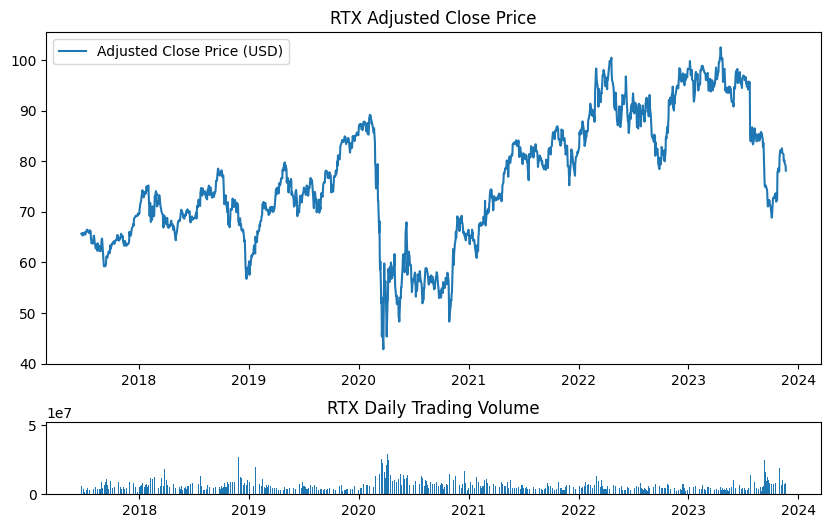

In [105]:
# Visualize historical data
# Adjusted Close over time
# Volume over time

top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4) 
top.plot(historical_df.index, historical_df['Adj Close'], label = 'Adjusted Close Price (USD)') 
plt.title('RTX Adjusted Close Price') 
plt.legend(loc=2) 

bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4) 
bottom.bar(historical_df.index, historical_df["Volume"]) 
plt.title('RTX Daily Trading Volume') 
plt.gcf().set_size_inches(10,6) 
plt.subplots_adjust(hspace=0.8)

### 7. Merging Sentiment data with historical data

In [116]:
# Merging and removing days that have no corresponding article

merged_matching_df = historical_df.merge(article_sentiments_df, how='inner', left_index=True, right_index=True)

In [117]:
merged_matching_df

,Open,High,Low,Close,Adj Close,Volume,Ticker Symbol,Publish Date,Title,Body Text,URL,Negative Score,Neutral Score,Positive Score,Compound Score
Date,,,,,,,,,,,,,,,
2017-06-23,76.784142,77.054749,76.456894,76.916298,65.686562,6119398,RTX,2017-06-23,Layoffs planned at Carrier By Seeking Alpha,Please try another search,https://www.investing.com/news/stock-market-ne...,0.000,0.566,0.434,0.3182
2017-07-06,77.130272,77.407173,76.702332,76.708626,65.509193,4859480,RTX,2017-07-06,Oppenheimer Global ESG Revenue ETF (ESGF) June...,Please try another search,https://www.investing.com/news/stock-market-ne...,0.000,0.566,0.434,0.3182
2017-07-07,76.954056,77.344238,76.803024,77.161736,65.896141,2801248,RTX,2017-07-07,United Tech tops Dow in week following strong ...,Please try another search,https://www.investing.com/news/stock-market-ne...,0.000,0.566,0.434,0.3182
2017-07-10,77.237259,77.872879,76.998116,77.444931,66.137993,3262376,RTX,2017-07-10,"Ingersoll-Rand may split into two companies, S...",© Reuters. Ingersoll-Rand may split into two c...,https://www.investing.com/news/stock-market-ne...,0.000,1.000,0.000,0.0000
2017-07-25,76.714912,76.777847,75.512901,75.783508,64.719147,7629425,RTX,2017-07-25,S&P 500 closes in record territory on bullish ...,"Published Jul 25, 2017 04:27PM ET\n\n© Reuters...",https://www.investing.com/news/stock-market-ne...,0.028,0.894,0.078,0.9274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31,78.849998,81.550003,78.730003,81.389999,80.794441,18663800,RTX,2023-10-31,"Raytheon, Kongsberg to further develop NASAMS ...","Published Oct 31, 2023 05:38AM ET\n\n© Reuters...",https://www.investing.com/news/stock-market-ne...,0.043,0.815,0.142,0.9360
2023-11-02,82.349998,83.199997,82.230003,82.779999,82.174271,15755700,RTX,2023-11-02,RTX recovers from Pratt & Whitney engine issue...,"Published Nov 02, 2023 04:57AM ET\n\n© Reuters...",https://www.investing.com/news/stock-market-ne...,0.057,0.798,0.145,0.9891
2023-11-09,83.660004,83.849998,82.139999,82.430000,81.826828,9638100,RTX,2023-11-09,Boeing sees minor recovery amid mixed market r...,"Published Nov 09, 2023 01:23AM ET\n\n© Reuters...",https://www.investing.com/news/stock-market-ne...,0.013,0.900,0.086,0.8779


In [124]:
# Merging and substituting the sentiment score of days with no article to 0.0
# Days with no articles/news are seen as 'neutral' with a 0.0 score

merged_substituted_df = historical_df.merge(article_sentiments_df, how='left', left_index=True, right_index=True)
sentiment_columns = ['Negative Score', 'Neutral Score', 'Positive Score', 'Compound Score']
merged_substituted_df[sentiment_columns] = merged_substituted_df[sentiment_columns].fillna(0.0)
merged_substituted_df['Ticker Symbol'] = merged_substituted_df['Ticker Symbol'].fillna(ticker_symbol)

In [125]:
merged_substituted_df

,Open,High,Low,Close,Adj Close,Volume,Ticker Symbol,Publish Date,Title,Body Text,URL,Negative Score,Neutral Score,Positive Score,Compound Score
Date,,,,,,,,,,,,,,,
2017-06-23,76.784142,77.054749,76.456894,76.916298,65.686562,6119398,RTX,2017-06-23,Layoffs planned at Carrier By Seeking Alpha,Please try another search,https://www.investing.com/news/stock-market-ne...,0.000,0.566,0.434,0.3182
2017-06-26,77.035873,77.463814,76.658279,76.696037,65.498444,2613111,RTX,NaN,NaN,NaN,NaN,0.000,0.000,0.000,0.0000
2017-06-27,76.727501,76.865952,76.469475,76.519821,65.347954,2706226,RTX,NaN,NaN,NaN,NaN,0.000,0.000,0.000,0.0000
2017-06-28,76.821899,77.155441,76.582756,77.092514,65.837029,2862107,RTX,NaN,NaN,NaN,NaN,0.000,0.000,0.000,0.0000
2017-06-29,77.042168,77.067337,75.909378,76.557587,65.380203,3747815,RTX,NaN,NaN,NaN,NaN,0.000,0.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-15,80.510002,81.250000,79.779999,80.629997,80.040001,10757800,RTX,2023-11-15,RTX's Pratt & Whitney Wins $870M Contract for ...,"Published Nov 15, 2023 09:05AM ET\n\nRTX's (RT...",https://www.investing.com/news/assorted/rtxs-p...,0.007,0.879,0.114,0.9571
2023-11-16,80.470001,80.830002,79.930000,80.230003,80.230003,7578700,RTX,2023-11-16,Lockheed Martin shares edge up amid broader ma...,"Published Nov 15, 2023 10:45PM ET\n\nLMT +0.39...",https://www.investing.com/news/stock-market-ne...,0.018,0.848,0.134,0.9887
2023-11-17,80.639999,80.680000,79.419998,79.680000,79.680000,7343900,RTX,NaN,NaN,NaN,NaN,0.000,0.000,0.000,0.0000


### 8. Saving Merged dataframe

In [ ]:
# Save dataframe
_df.to_pickle(f"../data/processed/{ticker_symbol}_article_sentiments_new_df.pkl")
_df.to_csv(f"../data/processed/{ticker_symbol}_article_sentiments_new_df.csv", sep=',', encoding='utf-8', header=True)